In [283]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os, random

K = 10

In [274]:
def load_image_as_grayscale(image_path: str) -> np.ndarray:
    return cv.imread(image_path, cv.IMREAD_GRAYSCALE)    

In [275]:

def load_training_set(resources_path= "resources/images/"):
    labels = []
    images = []
    file_names = []
    for subdir, dirs, files in os.walk(resources_path):
        file_name = random.choice(os.listdir(subdir))
        img = load_image_as_grayscale(os.path.join(subdir, file_name))
        if img is not None:
            file_names.append(file_name)
            labels.append(subdir.split('/')[-1])
            images.append(img)
    return labels, images, file_names
training_set_labels, training_set_images, training_file_names = load_training_set()


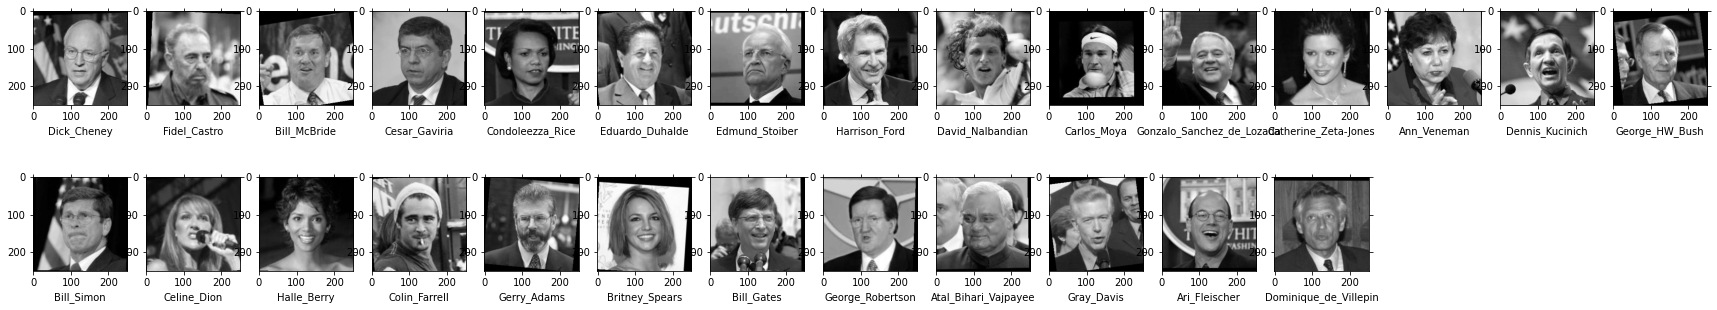

In [276]:
width, height = training_set_images[0].shape
training_set_matrix = np.ndarray(shape=(len(training_set_labels), width * height), dtype=np.float64)
training_set_size = len(training_set_labels)

fig = plt.figure(figsize=(30, 30))
for i in range(training_set_size):
    training_set_matrix[i, :] = np.array(training_set_images[i], dtype=np.float64).flatten()
    fig.add_subplot(10, 15, i+1).set_xlabel(training_set_labels[i])
    plt.imshow(training_set_images[i], cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='on', bottom='off',top='off',right='off',left='off', which='both')
plt.show()



In [152]:
def load_test_set(files_to_ignore_list, resources_path= "resources/images/"):
    images = []
    file_names = []
    for subdir, dirs, files in os.walk(resources_path):
        file = random.choice(os.listdir(subdir))
        img = load_image_as_grayscale(os.path.join(subdir, file))
        if img is not None and file not in files_to_ignore_list:
            file_names.append(file)
            images.append(img)
    return images, file_names
test_set_images, test_file_names = load_test_set(training_file_names)

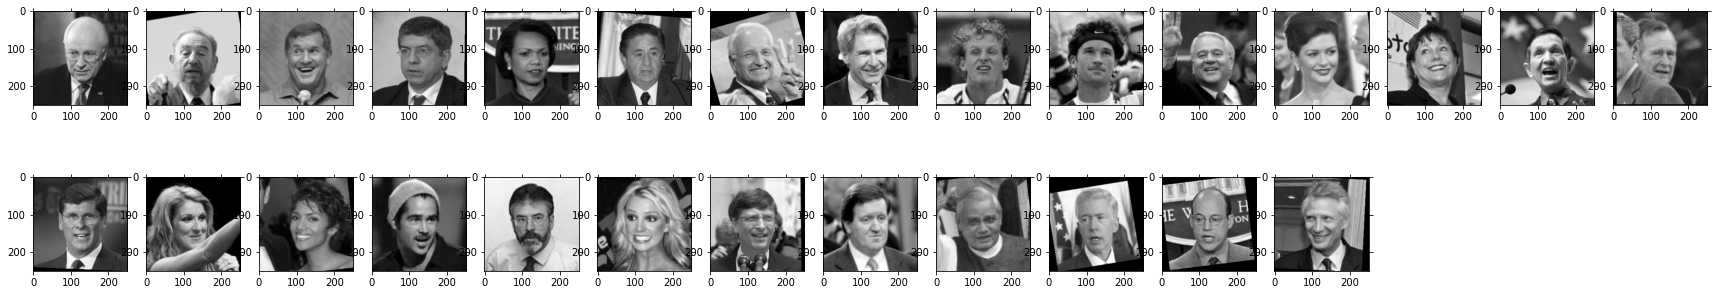

In [277]:
test_set_matrix = np.ndarray(shape=(len(test_set_labels), width * height), dtype=np.float64)
test_set_size = len(test_set_labels)

fig = plt.figure(figsize=(30, 30))
for i in range(test_set_size):
    test_set_matrix[i, :] = np.array(test_set_images[i], dtype=np.float64).flatten()
    fig.add_subplot(10, 15, i+1)
    plt.imshow(test_set_images[i], cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='on', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

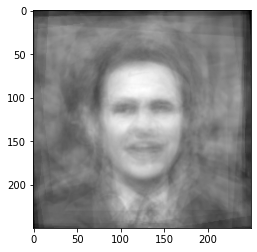

In [284]:
meanface = np.zeros((1, width * height))

for vector in training_set_matrix:
    meanface = np.add(meanface, vector)
meanface_vector = np.divide(meanface, float(training_set_size)).flatten()
plt.imshow(meanface_vector.reshape(height, width), cmap='gray')

In [281]:
normalized_training_matrix = np.ndarray(shape=(training_set_size, height*width))
for i in range(training_set_size):
    normalized_training_matrix[i] = np.subtract(training_set_matrix[i], meanface_vector)

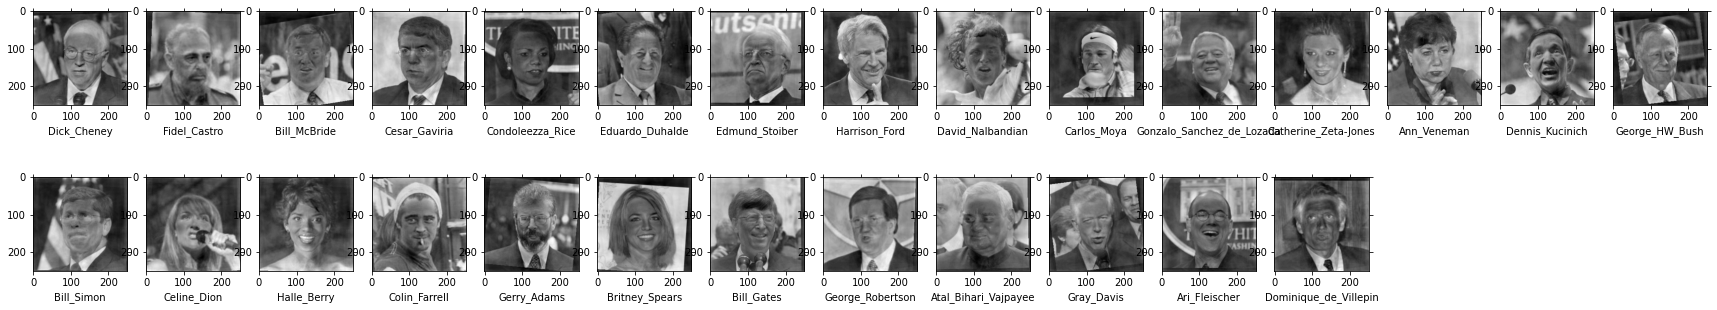

In [285]:
fig = plt.figure(figsize=(30, 30))
for i in range(training_set_size):
    eigenface = normalized_training_matrix[i].reshape(height, width)
    fig.add_subplot(10, 15, i+1).set_xlabel(test_set_labels[i])
    plt.imshow(eigenface, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='on', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [286]:
covariance_matrix = np.divide(np.cov(normalized_training_matrix), training_set_size)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

In [287]:
decreasing_order = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[decreasing_order]
eigenvectors = eigenvectors[:, decreasing_order]

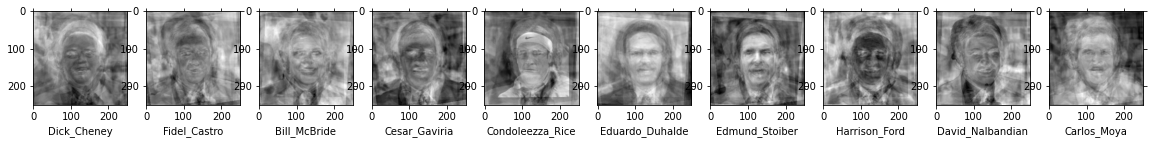

In [288]:
# find and plot K significant eigen faces
k_top_components_matrix = np.array(eigenvectors[:K]).transpose()
eiganspace = np.dot(training_set_matrix.transpose(), k_top_components_matrix).transpose()

fig = plt.figure(figsize=(30, 30))
for i in range(K):
    eigenface = eiganspace[i].reshape(height, width)
    fig.add_subplot(10, 15, i+1).set_xlabel(test_set_labels[i])
    plt.imshow(eigenface, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='on', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [289]:
weights = np.array([np.dot(eiganspace, column_vector) for column_vector in normalized_training_matrix])

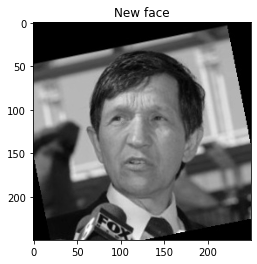

In [290]:
new_face = load_image_as_grayscale("resources/images/Dennis_Kucinich/Dennis_Kucinich_0005.jpg")
plt.imshow(new_face, cmap='gray')
plt.title("New face")
plt.show()

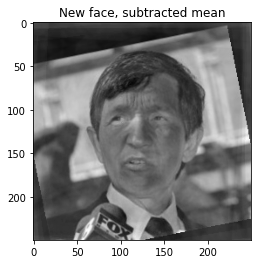

In [291]:
new_face_vector = np.array(new_face, dtype=np.float64).flatten()
new_face_minus_mean = np.subtract(new_face_vector, meanface_vector)
plt.imshow(new_face_minus_mean.reshape(height, width), cmap="gray")
plt.title("New face, subtracted mean")
plt.show()

In [306]:
def classify(image_path=None, image=None, eigenspace=None, weights=None):
    if image_path is None and image is not None:
        subject = image
    elif image_path is not None and image is None:
        subject = load_image_as_grayscale(image_path)
    else:
        raise Exception("Please pass image_path OR image, not both!")
    subject_vector = np.array(subject, dtype=np.float64).flatten()
    normalized_subjec_vector = np.subtract(subject_vector, meanface_vector)
    weights_for_subject = np.dot(eiganspace, normalized_subjec_vector)
    diff = weights - weights_for_subject
    norms_of_diff = np.linalg.norm(diff, axis=1)
    minimal_diff_norm_index = np.argmin(norms_of_diff)

    t1 = 12363829
    if norms_of_diff[minimal_diff_norm_index] < t1:
        fig = plt.figure(figsize=(30, 30))
        fig.add_subplot(10, 15, 1).set_xlabel(f"Matched: {training_set_labels[minimal_diff_norm_index]}", color='g')
        plt.imshow(test_set_images[minimal_diff_norm_index], cmap='gray')
        plt.tick_params(labelleft='off', labelbottom='on', bottom='off',top='off',right='off',left='off', which='both')
        plt.show()
    
    plt.show()
        

classify("resources/images/Dennis_Kucinich/Dennis_Kucinich_0005.jpg", None, eiganspace, weights)

In [303]:
classify("resources/images/Bill_Simon/Bill_Simon_0015.jpg", None, eiganspace, weights)

In [304]:
classify("resources/images/Fidel_Castro/Fidel_Castro_0004.jpg", None, eiganspace, weights)

Wanted label is: Dick_Cheney
Wanted label is: Fidel_Castro
Wanted label is: Bill_McBride
Wanted label is: Cesar_Gaviria


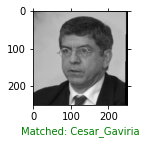

Wanted label is: Condoleezza_Rice


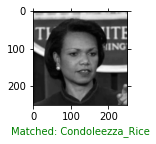

Wanted label is: Eduardo_Duhalde
Wanted label is: Edmund_Stoiber
Wanted label is: Harrison_Ford


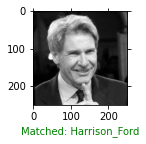

Wanted label is: David_Nalbandian
Wanted label is: Carlos_Moya
Wanted label is: Gonzalo_Sanchez_de_Lozada


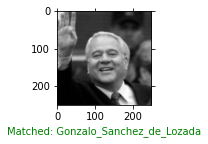

Wanted label is: Catherine_Zeta-Jones
Wanted label is: Ann_Veneman
Wanted label is: Dennis_Kucinich


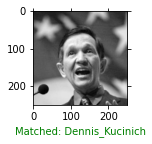

Wanted label is: George_HW_Bush
Wanted label is: Bill_Simon
Wanted label is: Celine_Dion
Wanted label is: Halle_Berry
Wanted label is: Colin_Farrell
Wanted label is: Gerry_Adams
Wanted label is: Britney_Spears
Wanted label is: Bill_Gates


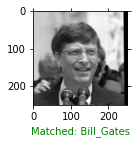

Wanted label is: George_Robertson
Wanted label is: Atal_Bihari_Vajpayee
Wanted label is: Gray_Davis
Wanted label is: Ari_Fleischer
Wanted label is: Dominique_de_Villepin


In [307]:
for i in range(test_set_size):
    print(f"Wanted label is: {test_set_labels[i]}")
    classify(None, test_set_images[i], eiganspace, weights)